## Project 1

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File.

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Part 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)


### Part 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)
2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)
3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

## Submission (10/100 pts)

Submit your work in a well-organized GitHub repo, where the code is appropriately commented and all members of the group have made significant contributions to the commit history. (10/100 pts)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import os
os.listdir()
os.listdir('sample_data')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'sample_data'

In [ ]:
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

In [ ]:
df = df[df["ELIGSTAT"] == 1]
df = df[df["MORTSTAT"].notna()]

print("Shape:", df.shape)
print("Death rate:", df["MORTSTAT"].mean())
print(df["MORTSTAT"].value_counts())

Shape: (5445, 151)
Death rate: 0.3076216712580349
MORTSTAT
0.0    3770
1.0    1675
Name: count, dtype: int64


## Description of Key Mortality Variables

### ELIGSTAT – Linkage Eligibility Status

The variable **ELIGSTAT** indicates whether a survey participant was eligible for linkage to the National Death Index (NDI) for mortality follow-up. In the public-use linked mortality files, eligibility is determined based on the availability of sufficient identifying information.

The coding is as follows:

- **1** = Eligible for mortality linkage  
- **2** = Under age 18 and not eligible for public-use mortality release  
- **3** = Not linkage-eligible due to insufficient identifying data  

In this analysis, we restrict the dataset to individuals with `ELIGSTAT = 1` to ensure that mortality outcomes are valid and interpretable.

---

### MORTSTAT – Mortality Status

The variable **MORTSTAT** represents the participant’s vital status at the end of the mortality follow-up period. This variable serves as the primary outcome for mortality classification.

The coding is as follows:

- **0** = Assumed alive  
- **1** = Assumed deceased  

Vital status is determined through probabilistic linkage to the National Death Index. Only linkage-eligible participants have valid mortality status values. In this project, **MORTSTAT is used as the dependent variable in mortality prediction models.**

---

### PERMTH_INT – Follow-up Time (Person-Months from Interview Date)

The variable **PERMTH_INT** represents the number of person-months from the date of the participant’s interview until either:

- The date of death (if deceased), or  
- The end of the mortality follow-up period (December 31, 2019), if assumed alive.

This variable captures survival duration and is useful for time-to-event analyses. However, it is not used as a predictor variable in the classification model because it contains post-baseline follow-up information and would introduce data leakage.

---

### RIDAGEEX – Age at Examination

The variable **RIDAGEEX** indicates the participant’s age in years at the time of examination. Age is a fundamental demographic variable and is strongly associated with mortality risk.

In predictive modeling, age is expected to be one of the most influential predictors of mortality, as mortality risk increases substantially across the lifespan.

---

Together, these variables define eligibility, outcome status, follow-up duration, and a key demographic risk factor. Proper understanding of these variables is essential to ensure valid modeling decisions and appropriate interpretation of mortality predictions.

## Data Selection and Integration

### Rationale for Data Selection

The objective of this project is to predict mortality status (**MORTSTAT**) and survival time in person-months (**PERMTH_INT**) using demographic, behavioral, and health-related variables from NHANES 1999–2000.

To accomplish this, we selected variables from the following NHANES components:

1. **Demographic Data (DEMO.xpt)**  
   This file includes core demographic variables such as:
   - Age at examination (RIDAGEEX)
   - Sex (RIAGENDR)
   - Race/ethnicity (RIDRETH1)
   - Socioeconomic indicators (e.g., education, income proxies)

   These variables are foundational predictors of mortality risk and are commonly used in epidemiological modeling.

2. **Mortality Linkage File (Linked Mortality File, 1999–2000)**  
   This file provides:
   - Mortality status (MORTSTAT)
   - Eligibility status (ELIGSTAT)
   - Follow-up time in person-months (PERMTH_INT)
   - Cause-of-death indicators

   This file supplies the outcome variables required for both classification (mortality) and regression (life expectancy proxy).

Additional behavioral or health variables (if included in your model, such as smoking, BMI, hypertension, or diabetes indicators) were selected based on established associations with mortality risk in public health literature.

Overall, the selected variables represent a combination of demographic, socioeconomic, and clinical risk factors that are theoretically and empirically linked to mortality outcomes.

---

### Data Merging Procedure

All NHANES datasets contain a unique respondent identifier variable, **SEQN**.  
This variable was used as the merge key to combine files.

The datasets were merged using an inner join:

- Demographic file (DEMO.xpt)
- Linked Mortality File (linked_mortality_file_1999_2000.csv)

The merge ensured that each observation corresponds to a single participant with both baseline demographic data and mortality follow-up information.

After merging, the resulting dataframe contains 151 variables and 9,965 total observations before filtering.

---

### Handling Linkage Eligibility

Because mortality status is only defined for linkage-eligible individuals, we restricted the dataset to:

- `ELIGSTAT == 1` (eligible for linkage)
- Non-missing `MORTSTAT` values

This resulted in:

- **5,445 eligible participants**
- 1,675 deceased (30.76%)
- 3,770 alive (69.24%)

This restriction ensures that mortality outcomes are valid and interpretable.

---

### Documentation of Missing Values

Missing values are present in several variables for the following reasons:

1. Participants under age 18 are coded as ineligible (ELIGSTAT = 2), resulting in missing mortality outcomes.
2. Some health and behavioral variables contain item nonresponse.
3. Follow-up time variables are missing for linkage-ineligible participants.

After filtering to eligible individuals, mortality status contains no missing values.  
Other predictor variables were evaluated for missingness using summary statistics and will be handled appropriately (e.g., removal, imputation, or encoding) prior to model fitting.

---

### Summary

The final analytical dataset combines demographic and mortality follow-up data using SEQN as the merge key. The selected variables were chosen based on epidemiological relevance to mortality risk, ensuring theoretical justification for predictive modeling.

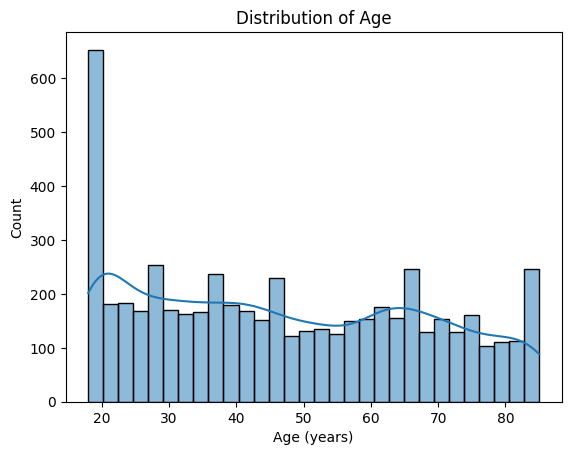

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["RIDAGEYR"], bins=30, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.show()

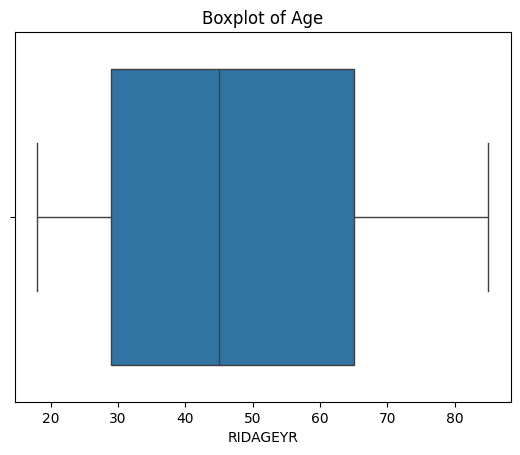

In [ ]:
sns.boxplot(x=df["RIDAGEYR"])
plt.title("Boxplot of Age")
plt.show()

In [ ]:
df["RIDAGEYR"].skew()

np.float64(0.20456483342053236)

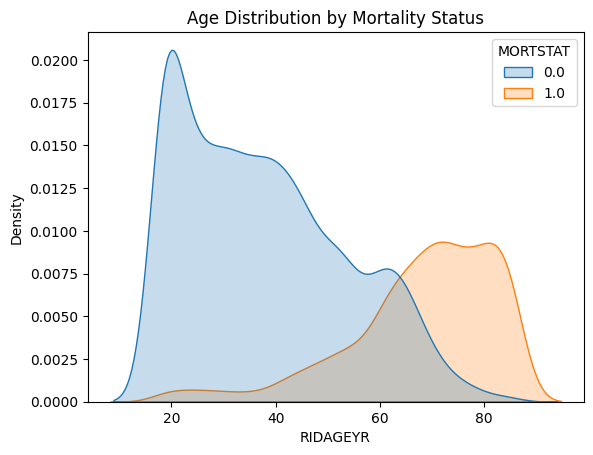

In [ ]:
sns.kdeplot(data=df, x="RIDAGEYR", hue="MORTSTAT", fill=True)
plt.title("Age Distribution by Mortality Status")
plt.show()

Age Distribution: The distribution of age is approximately symmetric with mild right skew (skewness ≈ 0.20). The sample spans a wide adult age range without extreme outliers. Age appears well-behaved and suitable for inclusion in predictive modeling. Given the strong theoretical relationship between age and mortality risk, this variable is expected to be an important predictor.

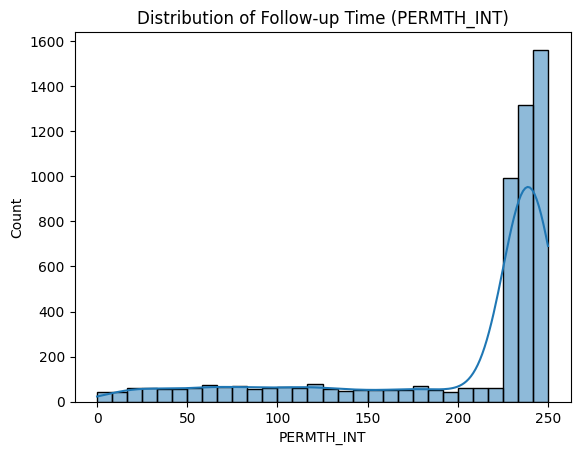

Skewness: -1.602977073137749


In [ ]:
sns.histplot(df["PERMTH_INT"], bins=30, kde=True)
plt.title("Distribution of Follow-up Time (PERMTH_INT)")
plt.show()

print("Skewness:", df["PERMTH_INT"].skew())

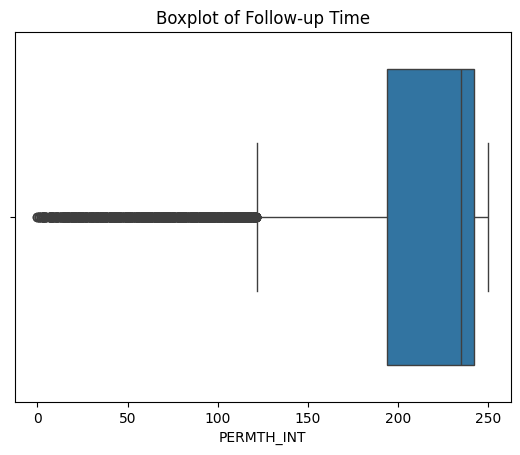

In [ ]:
sns.boxplot(x=df["PERMTH_INT"])
plt.title("Boxplot of Follow-up Time")
plt.show()

The distribution of follow-up time is strongly left-skewed (skewness ≈ -1.60). Most participants remain alive through the end of the follow-up period, resulting in clustering near the maximum follow-up duration (approximately 240–250 months). A smaller subset of individuals have shorter follow-up times due to earlier mortality, producing a long left tail.

The boxplot indicates numerous lower-end outliers; however, these reflect legitimate early mortality events rather than data errors. This skewed structure is typical in survival data and should be considered when modeling life expectancy.

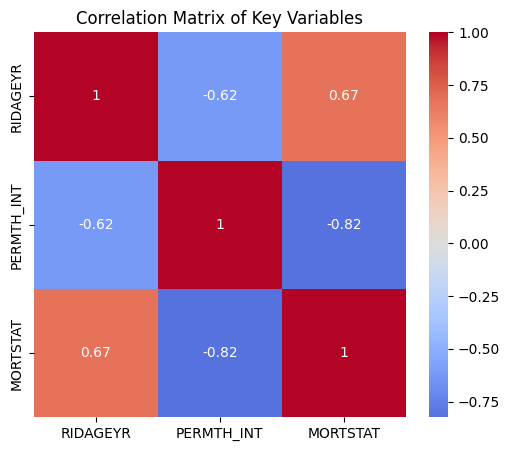

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select key numeric variables
numeric_vars = ["RIDAGEYR", "PERMTH_INT", "MORTSTAT"]

corr_matrix = df[numeric_vars].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Key Variables")
plt.show()

Correlation Analysis: The correlation matrix reveals several meaningful relationships among key variables. Age (RIDAGEYR) is strongly positively correlated with mortality status (MORTSTAT, r = 0.67), indicating that older individuals are substantially more likely to be deceased at follow-up. Age is moderately negatively correlated with follow-up time (PERMTH_INT, r = -0.62), suggesting that older participants tend to have shorter survival duration.

Most notably, follow-up time is very strongly negatively correlated with mortality status (r = -0.82). This is expected, as deceased individuals have shorter observed follow-up periods. Because PERMTH_INT is closely tied to the outcome variable, it should not be used as a predictor in mortality classification models to avoid data leakage.

In [ ]:
# Gender × Mortality
ct_gender = pd.crosstab(df["RIAGENDR"], df["MORTSTAT"], margins=True)
ct_gender

MORTSTAT,0.0,1.0,All
RIAGENDR,,,
1.0,1665,883,2548
2.0,2105,792,2897
All,3770,1675,5445


In [ ]:
pd.crosstab(df["RIAGENDR"], df["MORTSTAT"], normalize="index")

MORTSTAT,0.0,1.0
RIAGENDR,,
1.0,0.653454,0.346546
2.0,0.726614,0.273386


Contingency table analysis reveals a clear association between gender and mortality status. Among males, 34.6% are deceased at follow-up compared to 27.3% among females. This indicates a substantially higher mortality rate among men in the sample.

This pattern is consistent with well-documented demographic trends in the United States, where males exhibit higher all-cause mortality rates than females. Gender therefore appears to be an important predictor in mortality modeling.

In [ ]:
# Diabetes x Mortality
ct_diabetes = pd.crosstab(df["DIABETES"], df["MORTSTAT"], margins=True)
ct_diabetes

MORTSTAT,1.0,All
DIABETES,,
0.0,1451,1451
1.0,223,223
All,1674,1674


In [ ]:
pd.crosstab(df["DIABETES"], df["MORTSTAT"], normalize="index")

MORTSTAT,1.0
DIABETES,
0.0,1.0
1.0,1.0


In [ ]:
df_diab = df[df["DIABETES"].notna()]
pd.crosstab(
    df_diab["DIABETES"],
    df_diab["MORTSTAT"],
    normalize="index"
)

MORTSTAT,1.0
DIABETES,
0.0,1.0
1.0,1.0


The DIABETES variable contains substantial missingness (approximately 69% of observations). Upon restricting to non-missing values, it becomes clear that DIABETES is only recorded for deceased participants. As a result, contingency tables comparing DIABETES and mortality are not meaningful, since no alive individuals have recorded diabetes status in this file. This suggests that DIABETES in the linked mortality file reflects cause-of-death coding rather than baseline health status.

Part 1 Summary: Overall, exploratory analysis indicates that age is approximately symmetric and well-behaved, while follow-up time is strongly left-skewed due to survival censoring. Mortality is strongly associated with age and gender, while follow-up time is highly correlated with mortality and therefore unsuitable as a predictive feature due to data leakage concerns. Categorical analyses reveal meaningful demographic disparities in mortality risk. These findings provide a clear understanding of the structure, distributional properties, and interrelationships within the data, informing appropriate modeling decisions.


## Part 2.1
### What is an observation?
In this dataset, an observation represents a single participant from the CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000) who has also been linked to the CDC Linked Mortality File (LMF, 1999-2000). Each observation contains baseline demographic, behavioral, and health data from NHANES, along with mortality follow-up information (e.g., vital status, follow-up duration) from the LMF.

### Missing data and its potential impact:
Missing data is present in several variables. Specifically:
- Eligibility (ELIGSTAT): Participants under age 18 are coded as ineligible (ELIGSTAT = 2), resulting in missing mortality outcomes for these individuals.
- Health and Behavioral Variables: Some variables from NHANES contain item nonresponse.
- Follow-up Time (PERMTH_INT): This variable is missing for linkage-ineligible participants.
- DIABETES variable: DIABETES status was only recorded for deceased participants. This indicates that the DIABETES variable in the linked mortality file might reflect cause-of-death coding rather than baseline health status


Data collectors and their purpose:
- CDC National Health and Nutritional Examination Survey (NHANES): Collected by the Centers for Disease Control and Prevention (CDC). NHANES is a program designed to assess the health and nutritional status of adults and children in the United States. It provides a comprehensive panel dataset on health and behavior.
- CDC Linked Mortality File (LMF):Collected by the CDC National Center for Health Statistics (NCHS). This file links NHANES participants to the National Death Index (NDI) to provide mortality follow-up information. Its purpose is to track the vital status and cause of death for NHANES participants over time.

The overall purpose of these combined datasets in this project is to predict who dies (MORTSTAT) and how long they live (PERMTH_INT) using $k$-NN classification and regression based on the rich demographic, behavioral, and health data available.

### Limitations to the analysis:
- Data Leakage: The PERMTH_INT (follow-up time) variable should not be used as a predictor in mortality classification models. This is because it contains post-baseline follow-up information (time until death or end of follow-up) and is highly correlated with MORTSTAT (mortality status), leading to data leakage.
- DIABETES Variable Interpretation: The DIABETES variable in the linked mortality file appears to be recorded only for deceased participants, suggesting it reflects cause-of-death coding rather than a baseline health status. This limits its utility as a direct predictor of baseline mortality risk and may require careful re-evaluation or exclusion if baseline health status for diabetes is desired.
- The analysis focuses on the 1999-2000 wave of NHANES. While this wave has the largest follow-up window, findings might not directly generalize to other NHANES waves or different time periods due to changes in health trends, medical advancements, or demographic shifts.
- Censoring in Follow-up Time: The PERMTH_INT variable is left-skewed due to censoring, as most participants remain alive through the end of the follow-up period. This characteristic requires appropriate survival analysis techniques or careful consideration when modeling life expectancy.

## Part 2.2

### Rationale of the variables
#### Outcomes:
*  MORTSTAT (mortality status): is a binary target (alive vs dead) --> classification
* PERMTH_INT (follow up time in terms of months): is a proxy for the amount of time survived during the follow up window (higher = lived longer in follow up)

#### Predictors
*  RIDAGEYR (Age, years): Mortality risk is usually the most predictive single variable and rises strongly with age. Also something that is related to survival time: older patients typically have shorter remaing survival in follow up.
* RIAGENDER (Sex): There is plenty of sex variations in mortality (biological + behavoral + healthcare utilization differences). Even after adjusting for age, mortality probability and survivor distributions often displays changes.
* DIABETES (Diabetes indicator): Major chronic condition associated with cardiovascular disese and all cause mortality.

In [ ]:
vars_num = ["RIDAGEYR", "PERMTH_INT"]
vars_cat = ["RIAGENDR", "DIABETES"]
target = "MORTSTAT"

df[vars_num].describe().T

df.groupby(target)[vars_num].describe().T

for v in vars_cat:
    print("\n", v)
    print(df[v].value_counts(dropna=False))
    print(pd.crosstab(df[v], df[target], normalize="index"))


 RIAGENDR
RIAGENDR
2.0    2897
1.0    2548
Name: count, dtype: int64
MORTSTAT       0.0       1.0
RIAGENDR                    
1.0       0.653454  0.346546
2.0       0.726614  0.273386

 DIABETES
DIABETES
NaN    3771
0.0    1451
1.0     223
Name: count, dtype: int64
MORTSTAT  1.0
DIABETES     
0.0       1.0
1.0       1.0


#### Interpretation
RIAGENDR=1 has a higher moratility rate 34.7% comapred to RIAGENDER=2 with a rate of 27.3%. Diabetes has 3771 missing values. So we need to view diabetes mortality patterns based on the non-missing subset.

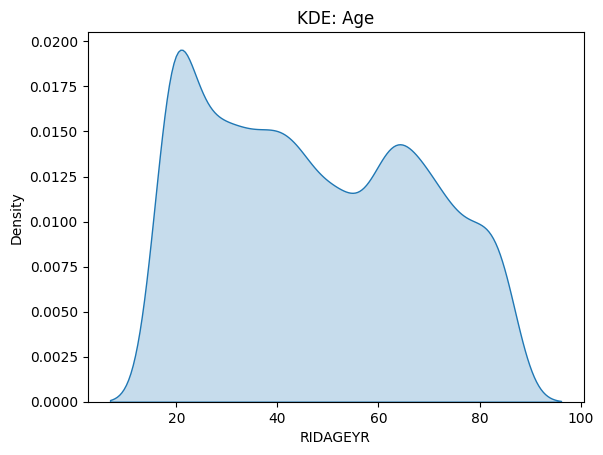

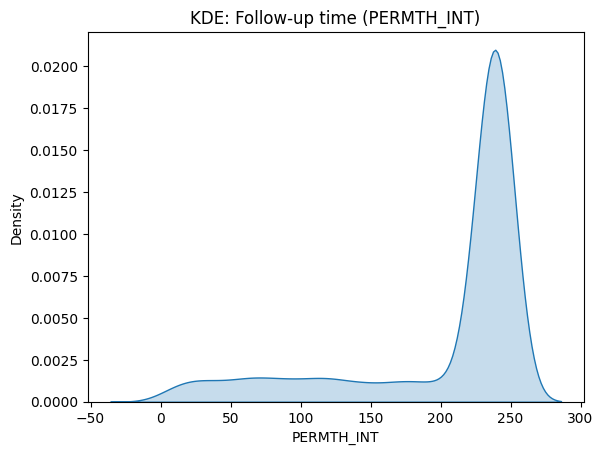

In [ ]:
# This is the Uncoditional KDEs
sns.kdeplot(data=df, x="RIDAGEYR", fill=True)
plt.title("KDE: Age")
plt.show()

sns.kdeplot(data=df, x="PERMTH_INT", fill=True)
plt.title("KDE: Follow-up time (PERMTH_INT)")
plt.show()

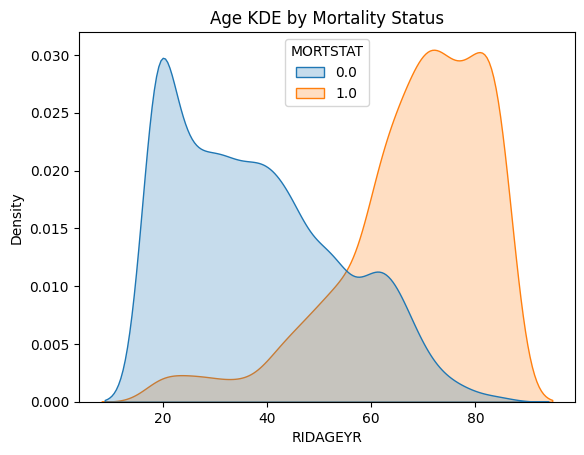

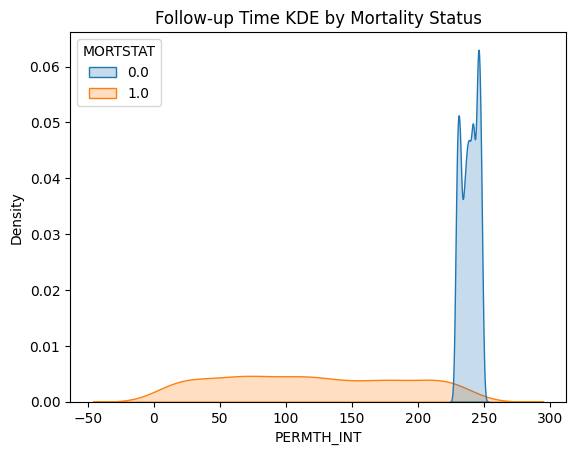

In [ ]:
# KDEs conditional on mortality
sns.kdeplot(data=df, x="RIDAGEYR", hue="MORTSTAT", fill=True, common_norm=False)
plt.title("Age KDE by Mortality Status")
plt.show()

sns.kdeplot(data=df, x="PERMTH_INT", hue="MORTSTAT", fill=True, common_norm=False)
plt.title("Follow-up Time KDE by Mortality Status")
plt.show()

#### Interpretation
Age KDE by mortality decreased the distribution which should be shifted right.
PERMTH_INT KDE by morality decreased should be shifted left while alive piles up near the max follow up duration (skewed)

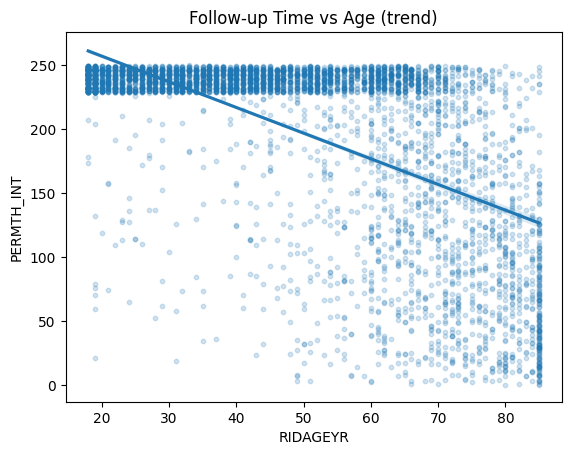

In [ ]:
# Scatterplot
sns.regplot(data=df, x="RIDAGEYR", y="PERMTH_INT", scatter_kws={"alpha":0.2, "s":10}, line_kws={})
plt.title("Follow-up Time vs Age (trend)")
plt.show()

#### Interpretation
Something we noticed here was there is a negative relationship. Older age led to a lower PERMTH_INT.


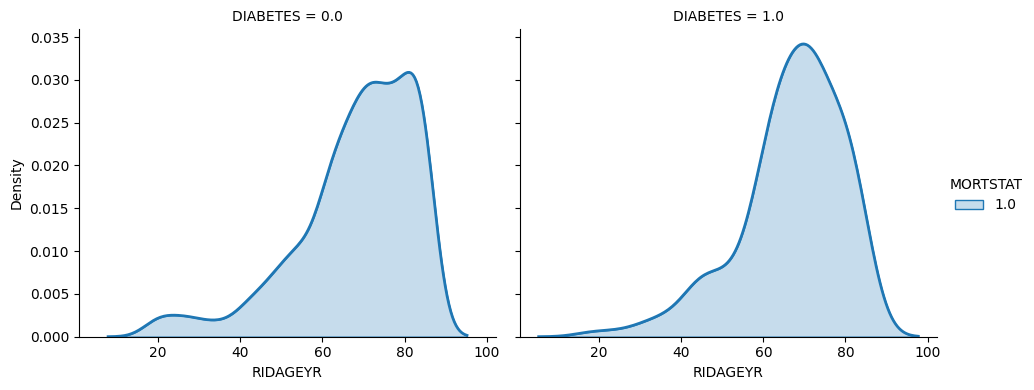

In [ ]:
#Conditional KDE
import seaborn as sns
import matplotlib.pyplot as plt
d = df.dropna(subset=["DIABETES","RIDAGEYR","MORTSTAT"])

g = sns.FacetGrid(d, col="DIABETES", hue="MORTSTAT", height=4, aspect=1.2)
g.map(sns.kdeplot, "RIDAGEYR", fill=False, linewidth=2)
g.map(sns.kdeplot, "RIDAGEYR", fill=True, alpha=0.25)
g.add_legend()
plt.show()

#### Patterns
* Age is related to mortality (very strong)
* Follow up time (PERMTH_INT) acts liek "time until death"
* Older age is associated with shorter follow up time
* Sex differences in mortality
* Diabetes is limited but suggestive

## Part 2.3
### Predicting Mortality


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

ctrl_list = ["RIDAGEYR", "RIAGENDR"] #Define variable list
dfMortality = df[ctrl_list + ["MORTSTAT"]].dropna() #Remove missing values
mortality = dfMortality["MORTSTAT"] #Define target
features = dfMortality[ctrl_list] #Define features

def minMaxFunction(x): #MinMax Scaling Function
    u = (x - min(x)) / (max(x) - min(x))
    return u

u = features.apply(minMaxFunction) #Apply Scaling to features

u_train, u_test, y_train, y_test = train_test_split(u, mortality, test_size = 0.2, random_state = 100) #Split data into 80% training set and 20% test set
kGrid = [(2*k+3) for k in range(0,40)] #Create grid
accuracyArray = []
for k in kGrid: #Loop through k values
    model = KNeighborsClassifier(n_neighbors = k)
    model = model.fit(u_train, y_train) #Fit model on training set
    accuracy = model.score(u_test, y_test) #Score model on test set
    accuracyArray.append(accuracy) #Add score to accuracy array
index = np.argmax(accuracyArray) 
k = kGrid[index] #Use max accuracy score as index into grid to obtain k value
print("K Value: ", k)

outputModel = KNeighborsClassifier(n_neighbors = k)
outputModel = outputModel.fit(u_train, y_train) #Fit model using k value
y_hat = outputModel.predict(u_test)
print(pd.crosstab(y_test, y_hat)) #Create confusion matrix
outputModel.score(u_test, y_test) #Output final accuracy score

K Value:  73
col_0     0.0  1.0
MORTSTAT          
0.0       702   54
1.0       104  229


0.8549127640036731

#### K Selection
* I selected k by first splitting the dataset into 80% training sets and 20% test sets. I then created a grid using an odd range and looped through every value on the grid. Each value was treated as a possible k value, and a kNN model was fitted on the training set and scored on the test set. Every accuracy score was appended to an array and the highest accuracy score in the array was used as an index into the grid to determine the best k value.
#### Performance
* The model achieved 85.49% accuracy with the confusion matrix showing that 702 alive individuals were predicted correctly and 229 dead individuals were predicted correctly. The confusion matrix also shows 54 alive individuals being incorrectly predicted and 104 dead individuals being incorrectly predicted. Diabetes wasn't used as a variable due to it missing a large amount of values and it only being recorded for deceased individuals. Overall, using age and sex as variables in the model resulted in high predictive performance serving as a reliable source of interpretation for the dataset.



## Part 2.4
### Predicting Life Expectancy